## Red generativa adversaria evolutiva para el procesamiento de imagenes esteganograficas
* Alumno: Imanol Brayan Moscoso Apaza

In [1]:
!pip install tensorflow
!pip install opencv-python
!pip install pygad

In [1]:
import os
import keras
import matplotlib.pyplot as plt
import time
import pygad.kerasga
import sys
import numpy as np
import cv2
import tensorflow as tf
import pathlib
import pygad
from tensorflow.keras.layers import Conv2D, Activation, AveragePooling2D, Conv2DTranspose, Concatenate, Input, GroupNormalization, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

(256, 256, 3)

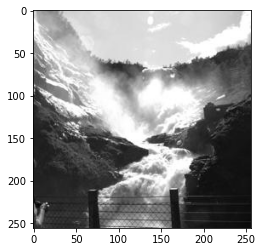

In [2]:
coverimg = image.load_img("./dataset/BOSSbase-train-test/cover/1000.png")
plt.imshow(coverimg)
cv2.imread("./dataset/BOSSbase-train-test/cover/1000.png").shape

(256, 256, 3)

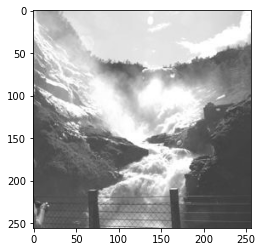

In [3]:
stegoimg = image.load_img("./dataset/BOSSbase-train-test/stego/1000.png")
plt.imshow(stegoimg, alpha = 0.8, cmap = 'gray')
cv2.imread("./dataset/BOSSbase-train-test/stego/1000.png").shape

### Cargar las imagenes

In [4]:
def load_data(path):
  imgPath = list(pathlib.Path(path).glob('*.*'))
  images = []
  for i in imgPath:
    i = cv2.imread(str(i),0)
    i = i/255
    i = cv2.resize(i, (256,256))
    images.append(i)
  return np.array(images)

In [5]:
stegoImages = load_data("./dataset/BOSSbase-train-test/stego")
stegoImages.shape

(3500, 256, 256)

In [6]:
coverImages = load_data("./dataset/BOSSbase-train-test/cover")
coverImages.shape

(3500, 256, 256)

### Divición de la base de datos

In [7]:
i = 600
testCover = coverImages[:i]
testStego = stegoImages[:i]
trainCover = coverImages[i:]
trainStego = stegoImages[i:]
testCover.shape, testStego.shape, trainCover.shape, trainStego.shape

((600, 256, 256), (600, 256, 256), (2900, 256, 256), (2900, 256, 256))

### Funciones para crear el codificador y decodificador

In [8]:
def additLayers (inputs, activation, filter, padding, kernel, strides):
    x = inputs
    x = Activation(activation)(x)
    x = Conv2D(filter, kernel_size = kernel, padding = padding, strides = strides)(x)
    x = GroupNormalization(groups = filter)(x)
    return x

In [9]:
def convolution (inputs, filter, padding, strides, kernel, activation,conv_type):
  x = inputs
  x = Conv2D(filter, kernel_size = kernel, padding = padding, strides = strides)(x)
  x = GroupNormalization(groups = filter)(x)

  # para las capas del decodificador
  if conv_type =="decoder":
    x = additLayers(x, activation, filter*2, padding, kernel, strides)
    x = additLayers(x, activation, filter, padding, kernel, strides)

  x = tf.keras.layers.average([x, Conv2D(filter, kernel_size = 1, padding = 'same', strides = 1)(inputs)])
  x = Activation(activation)(x)
  return x

#### U-Net

In [10]:
def encoder(input, filter, padding, strides, kernel, activation):
  x = input
  x = convolution(x, filter, padding, strides, kernel, activation, "encoder")
  downsample = AveragePooling2D()(x)
  return downsample, x

In [11]:
def decoder(input, filter, skip, padding, strides, kernel, activation):
  x = input
  x = Conv2DTranspose(filter, kernel_size = kernel, padding = padding, strides = 2, activation = activation)(x)
  x = tf.keras.layers.average([x, skip])
  x = convolution(x, filter, padding, strides, kernel, activation, "decoder")
  return x

In [12]:
epochs = 100
batch = 16
eta = 0.001
weight_decay = 6e-8
coverShape = (256, 256, 1)
stegoShape = (256, 256, 1)

### Red del generador

In [13]:
def build_generator(input, filter, padding, strides, kernel, weights):
  x = input
  con1, skip1 = encoder(x, filter, padding = padding, strides = strides, kernel = kernel, activation = "LeakyReLU")
  con2, skip2 = encoder(con1, filter*2, padding = padding, strides = strides, kernel = kernel, activation = "LeakyReLU")
  con3, skip3 = encoder(con2, filter*4, padding = padding, strides = strides, kernel = kernel, activation = "LeakyReLU")
  con4, skip4 = encoder(con3, filter*8, padding = padding, strides = strides, kernel = kernel, activation = "LeakyReLU")
  con5, skip5 = encoder(con4, filter*16, padding = padding, strides = strides, kernel = kernel, activation = "LeakyReLU")

  deco = decoder(con5, filter*16, skip5, padding = padding, strides = strides, kernel = kernel, activation = "relu")
  deco1 = decoder(deco, filter*8, skip4, padding = padding, strides = strides, kernel = kernel, activation = "relu")
  deco2 = decoder(deco1, filter*4, skip3, padding = padding, strides = strides, kernel = kernel, activation = "relu")
  deco3 = decoder(deco2, filter*2, skip2, padding = padding, strides = strides, kernel = kernel, activation = "relu")
  deco4 = decoder(deco3, filter, skip1, padding = padding, strides = strides, kernel = kernel, activation = "relu")

  output = Conv2DTranspose(1, kernel_size = kernel, strides = strides, padding = padding, activation = 'sigmoid')(deco4)

  generator = Model(inputs = input, outputs = output, name = "generator")

  if weights != None:
    generator.load_weights('./weights/stego_generator.h5')

  generator.summary()

  return generator

In [14]:
G = build_generator(input = Input(shape = (256, 256, 1)), filter = 32, padding = 'same', kernel = 3, strides = 1, weights = None)

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 group_normalization (GroupNorm  (None, 256, 256, 32  64         ['conv2d[0][0]']                 
 alization)                     )                                                         

                                                                                                  
 average_pooling2d_4 (AveragePo  (None, 8, 8, 512)   0           ['activation_4[0][0]']           
 oling2D)                                                                                         
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 16, 16, 512)  2359808    ['average_pooling2d_4[0][0]']    
 ose)                                                                                             
                                                                                                  
 average_5 (Average)            (None, 16, 16, 512)  0           ['conv2d_transpose[0][0]',       
                                                                  'activation_4[0][0]']           
                                                                                                  
 conv2d_10

 conv2d_19 (Conv2D)             (None, 64, 64, 256)  295168      ['activation_11[0][0]']          
                                                                                                  
 group_normalization_12 (GroupN  (None, 64, 64, 256)  512        ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_12 (Activation)     (None, 64, 64, 256)  0           ['group_normalization_12[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 64, 64, 128)  295040      ['activation_12[0][0]']          
                                                                                                  
 group_normalization_13 (GroupN  (None, 64, 64, 128)  256        ['conv2d_20[0][0]']              
 ormalizat

                                )                                                                 
                                                                                                  
 group_normalization_19 (GroupN  (None, 256, 256, 32  64         ['conv2d_28[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 conv2d_29 (Conv2D)             (None, 256, 256, 32  1056        ['average_13[0][0]']             
                                )                                                                 
                                                                                                  
 average_14 (Average)           (None, 256, 256, 32  0           ['group_normalization_19[0][0]', 
                                )                                 'conv2d_29[0][0]']              
          

### Red del discriminador

In [15]:
def encoderDisc(input, filter, padding, strides, kernel, activation):
  x = input
  x = convolution(x, filter, padding, strides, kernel, activation, "encoder")
  downsample = AveragePooling2D()(x)
  return downsample

In [16]:
def build_discriminator(coverInput, stegoInput, filter, padding, strides, kernel, lossFn, learning_rate, weight_decay):
  x = tf.keras.layers.multiply([coverInput, stegoInput])
  con1 = encoderDisc(x, filter, padding = padding, strides = strides, kernel = kernel, activation = 'LeakyReLU')
  con2 = encoderDisc(con1, filter*2, padding = padding, strides = strides, kernel = kernel, activation = 'LeakyReLU')
  con3 = encoderDisc(con2, filter*4, padding = padding, strides = strides, kernel = kernel, activation = 'LeakyReLU')
  con4 = encoderDisc(con3, filter*8, padding = padding, strides = strides, kernel = kernel, activation = 'LeakyReLU')
  con5 = encoderDisc(con4, filter*16, padding = padding, strides = strides, kernel = kernel, activation = 'LeakyReLU')

  x = GlobalAveragePooling2D()(con5)
  x = Dropout(0.1)(x)
  x = Dense(1)(x)
  discriminator = Model(inputs = [stegoInput, coverInput], outputs = x, name = "discriminator")

  discriminator.compile(loss = lossFn, optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate, weight_decay = weight_decay))
  discriminator.summary()
  return discriminator

In [17]:
D = build_discriminator(coverInput = Input(shape = coverShape), stegoInput = Input(shape = stegoShape), filter = 32, padding = 'same', strides = 1, kernel = 3, lossFn = 'mse', learning_rate = eta, weight_decay = weight_decay)

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 multiply (Multiply)            (None, 256, 256, 1)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']    

 conv2d_39 (Conv2D)             (None, 16, 16, 512)  131584      ['average_pooling2d_8[0][0]']    
                                                                                                  
 average_19 (Average)           (None, 16, 16, 512)  0           ['group_normalization_24[0][0]', 
                                                                  'conv2d_39[0][0]']              
                                                                                                  
 activation_24 (Activation)     (None, 16, 16, 512)  0           ['average_19[0][0]']             
                                                                                                  
 average_pooling2d_9 (AveragePo  (None, 8, 8, 512)   0           ['activation_24[0][0]']          
 oling2D)                                                                                         
                                                                                                  
 global_av

### GAN

In [18]:
def GAN(discriminator, generator, coverInput, stegoInput, learning_rate, weight_decay,
                   lossFn):
  discriminator.trainable = False
  gan = Model(
      inputs = [coverInput],
      outputs = discriminator([generator(coverInput), coverInput],),
      name = 'gan'
  )
  gan.compile(loss = lossFn, optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate*0.5, weight_decay = weight_decay*0.5))
  gan.summary()
  return gan

In [19]:
gan = GAN(discriminator = D, generator = G, coverInput = Input(shape = coverShape), stegoInput = Input(shape = stegoShape), learning_rate = eta, weight_decay = weight_decay, lossFn = 'mse')

Model: "gan"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 generator (Functional)         (None, 256, 256, 1)  21747745    ['input_4[0][0]']                
                                                                                                  
 discriminator (Functional)     (None, 1)            1745601     ['generator[0][0]',              
                                                                  'input_4[0][0]']                
                                                                                                

In [20]:
#función para mostrar las imagenes junto al loss dell discriminador
def samples(generator, images, realStego):
  stego = tf.squeeze(generator.predict(images))
  all = np.vstack([realStego, stego])
  plt.figure(figsize = (12, 4))
  for i in range(16):
    plt.subplot(2, 8, (i + 1))
    plt.imshow(all[i], cmap = 'gray')
  plt.show()

### Inicio del primer entrenamiento

Epoch/Epochs: 0/100
discriminator loss: [tag: 0.5586282014846802,], generator loss: [tag: 0.252730131149292,]
1/1 [==============================] - 2s 2s/step


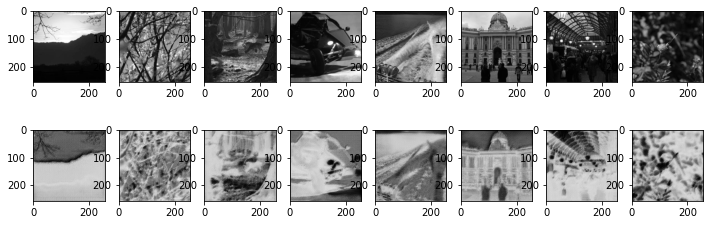

Epoch/Epochs: 10/100
discriminator loss: [tag: 0.24969469010829926,], generator loss: [tag: 0.26896926760673523,]
1/1 [==============================] - 1s 1s/step


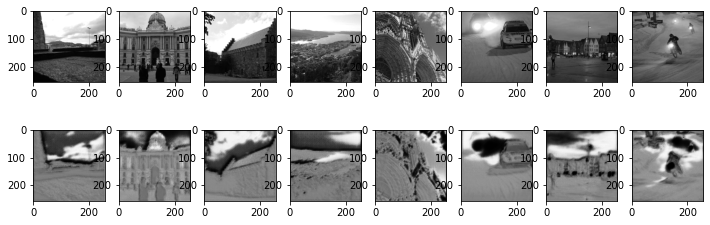

Epoch/Epochs: 20/100
discriminator loss: [tag: 0.37275582551956177,], generator loss: [tag: 0.0644892156124115,]
1/1 [==============================] - 1s 1s/step


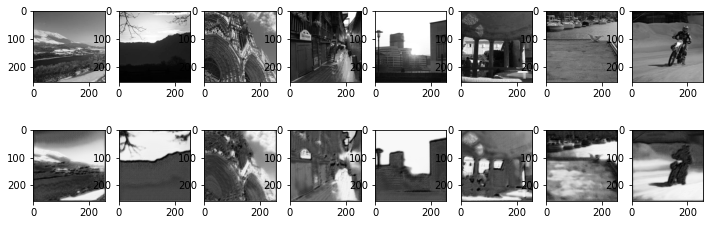

Epoch/Epochs: 30/100
discriminator loss: [tag: 0.30027857422828674,], generator loss: [tag: 0.03927471488714218,]
1/1 [==============================] - 1s 1s/step


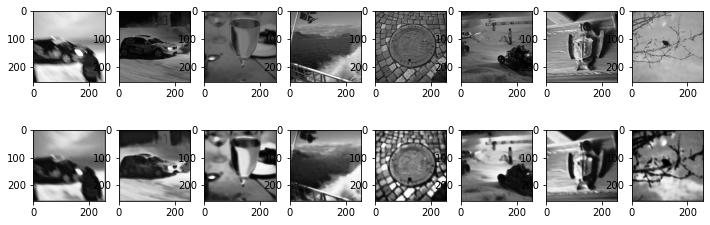

Epoch/Epochs: 40/100
discriminator loss: [tag: 0.26812881231307983,], generator loss: [tag: 0.14066174626350403,]
1/1 [==============================] - 1s 1s/step


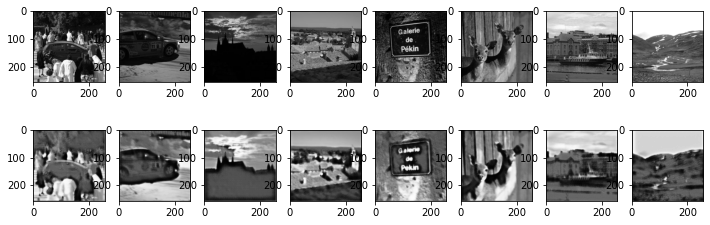

Epoch/Epochs: 50/100
discriminator loss: [tag: 0.29205065965652466,], generator loss: [tag: 0.12983356416225433,]
1/1 [==============================] - 1s 1s/step


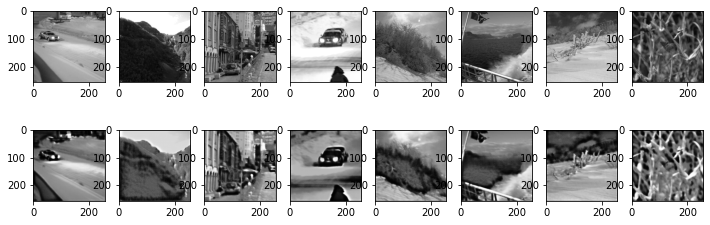

Epoch/Epochs: 60/100
discriminator loss: [tag: 0.28375914692878723,], generator loss: [tag: 0.16088485717773438,]
1/1 [==============================] - 1s 1s/step


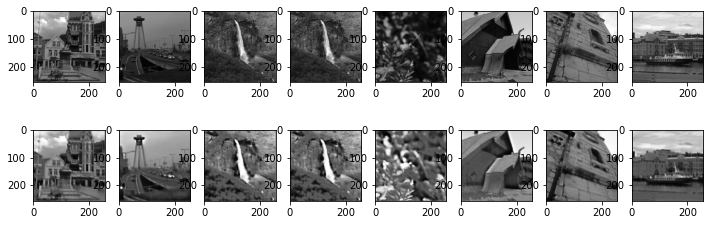

Epoch/Epochs: 70/100
discriminator loss: [tag: 0.2839491367340088,], generator loss: [tag: 0.1218736544251442,]
1/1 [==============================] - 1s 1s/step


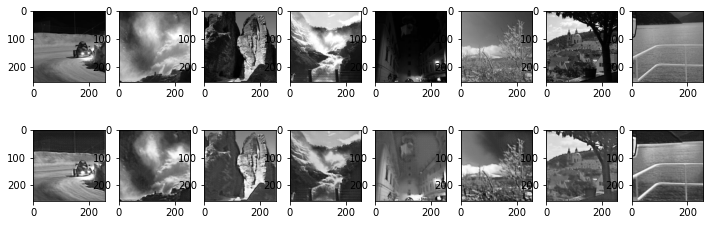

Epoch/Epochs: 80/100
discriminator loss: [tag: 0.25835317373275757,], generator loss: [tag: 0.20140689611434937,]
1/1 [==============================] - 1s 1s/step


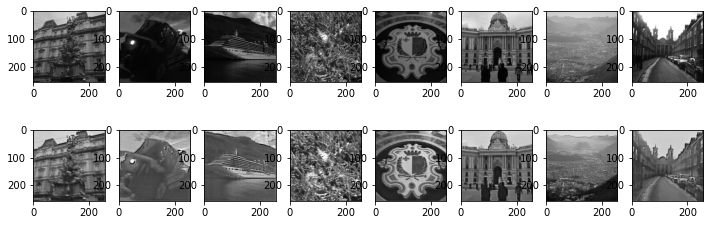

Epoch/Epochs: 90/100
discriminator loss: [tag: 0.2894861698150635,], generator loss: [tag: 0.12736235558986664,]
1/1 [==============================] - 1s 1s/step


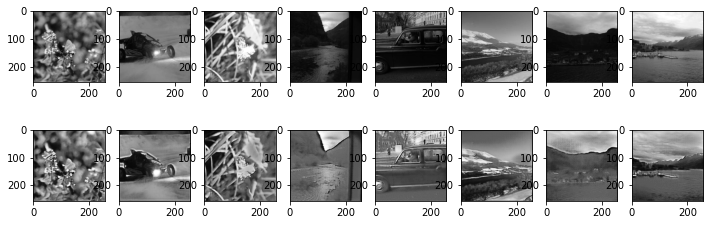

In [21]:
arrdisLoss = []
arrganLoss = []
for epoch in range(epochs):
    indexs = np.random.randint(0, len(trainCover), size = (batch, ))
    realCover = trainCover[indexs]
    realStego = trainStego[indexs]
    realTag = tf.ones(shape = (batch, ))
    fakeStego = tf.squeeze(G.predict([realCover], verbose = 0))
    fakeTag = tf.zeros(shape = (batch, ))
    allStego = np.vstack([realStego, fakeStego])
    allTags = np.hstack([realTag, fakeTag])
    allCover = np.vstack([realCover, realCover])
    dlossTag = D.train_on_batch([allStego, allCover], [allTags])
    glossTag = gan.train_on_batch([realCover], [realTag,])
    if epoch % 10 == 0:
        print('Epoch/Epochs: {}/{}'.format(epoch, epochs))
        print('discriminator loss: [tag: {},], generator loss: [tag: {},]'.format(dlossTag, glossTag))
        validIndexs = np.random.randint(0, len(testCover), size = (8, ))
        samples(G, testCover[validIndexs], testStego[validIndexs])
        arrdisLoss.append(dlossTag)
        arrganLoss.append(glossTag)

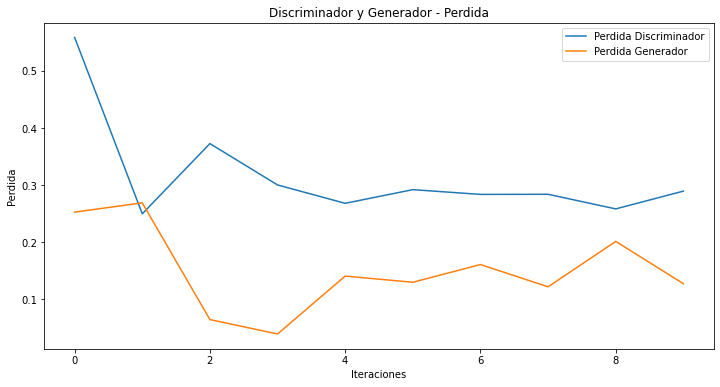

In [22]:
# Graficar el loss
plt.figure(figsize=(12, 6))
plt.plot(arrdisLoss, label='Perdida Discriminador')
plt.plot(arrganLoss, label='Perdida Generador')
plt.title('Discriminador y Generador - Perdida')
plt.xlabel('Iteraciones')
plt.ylabel('Perdida')
plt.legend()
plt.show()

In [23]:
G.save_weights('./weights/stego_generator.h5')

### Se carga los pesos actualizados
* Se congela las primeras capas para realizar el segundo entrenamiento

In [21]:
G = build_generator(input = Input(shape = (256, 256, 1)), filter = 32,
              padding = 'same', kernel = 3, strides = 1, weights = False)
for layer in G.layers[:20]:
  layer.trainable = False

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 256, 256, 32  320         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 group_normalization_25 (GroupN  (None, 256, 256, 32  64         ['conv2d_40[0][0]']              
 ormalization)                  )                                                         

                                                                                                  
 average_pooling2d_14 (AverageP  (None, 8, 8, 512)   0           ['activation_29[0][0]']          
 ooling2D)                                                                                        
                                                                                                  
 conv2d_transpose_6 (Conv2DTran  (None, 16, 16, 512)  2359808    ['average_pooling2d_14[0][0]']   
 spose)                                                                                           
                                                                                                  
 average_25 (Average)           (None, 16, 16, 512)  0           ['conv2d_transpose_6[0][0]',     
                                                                  'activation_29[0][0]']          
                                                                                                  
 conv2d_50

 conv2d_59 (Conv2D)             (None, 64, 64, 256)  295168      ['activation_36[0][0]']          
                                                                                                  
 group_normalization_37 (GroupN  (None, 64, 64, 256)  512        ['conv2d_59[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_37 (Activation)     (None, 64, 64, 256)  0           ['group_normalization_37[0][0]'] 
                                                                                                  
 conv2d_60 (Conv2D)             (None, 64, 64, 128)  295040      ['activation_37[0][0]']          
                                                                                                  
 group_normalization_38 (GroupN  (None, 64, 64, 128)  256        ['conv2d_60[0][0]']              
 ormalizat

                                )                                                                 
                                                                                                  
 group_normalization_44 (GroupN  (None, 256, 256, 32  64         ['conv2d_68[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 conv2d_69 (Conv2D)             (None, 256, 256, 32  1056        ['average_33[0][0]']             
                                )                                                                 
                                                                                                  
 average_34 (Average)           (None, 256, 256, 32  0           ['group_normalization_44[0][0]', 
                                )                                 'conv2d_69[0][0]']              
          

* gaGenerator es una copia de la red del generador para realizar el entrenamiento mediante algoritmos genéticos

In [22]:
gaGenerator = G

### Segundo entrenamiento del primer generador

In [23]:
G.compile(loss = tf.keras.losses.BinaryFocalCrossentropy(),
                  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001),
                  metrics = ['accuracy', tf.keras.metrics.Precision(name = 'precision'),
                             tf.keras.metrics.Recall(name = 'recall')])
G.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 256, 256, 32  320         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 group_normalization_25 (GroupN  (None, 256, 256, 32  64         ['conv2d_40[0][0]']              
 ormalization)                  )                                                         

                                                                                                  
 average_pooling2d_14 (AverageP  (None, 8, 8, 512)   0           ['activation_29[0][0]']          
 ooling2D)                                                                                        
                                                                                                  
 conv2d_transpose_6 (Conv2DTran  (None, 16, 16, 512)  2359808    ['average_pooling2d_14[0][0]']   
 spose)                                                                                           
                                                                                                  
 average_25 (Average)           (None, 16, 16, 512)  0           ['conv2d_transpose_6[0][0]',     
                                                                  'activation_29[0][0]']          
                                                                                                  
 conv2d_50

 conv2d_59 (Conv2D)             (None, 64, 64, 256)  295168      ['activation_36[0][0]']          
                                                                                                  
 group_normalization_37 (GroupN  (None, 64, 64, 256)  512        ['conv2d_59[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_37 (Activation)     (None, 64, 64, 256)  0           ['group_normalization_37[0][0]'] 
                                                                                                  
 conv2d_60 (Conv2D)             (None, 64, 64, 128)  295040      ['activation_37[0][0]']          
                                                                                                  
 group_normalization_38 (GroupN  (None, 64, 64, 128)  256        ['conv2d_60[0][0]']              
 ormalizat

                                )                                                                 
                                                                                                  
 group_normalization_44 (GroupN  (None, 256, 256, 32  64         ['conv2d_68[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 conv2d_69 (Conv2D)             (None, 256, 256, 32  1056        ['average_33[0][0]']             
                                )                                                                 
                                                                                                  
 average_34 (Average)           (None, 256, 256, 32  0           ['group_normalization_44[0][0]', 
                                )                                 'conv2d_69[0][0]']              
          

In [24]:
history = G.fit(trainCover, trainStego, epochs = 5, batch_size = 8, validation_data = (testCover, testStego), callbacks = [ tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss', mode = 'min', restore_best_weights = True)])

Epoch 1/5
363/363 [==============================] - 1871s 5s/step - loss: 0.1385 - accuracy: 0.0152 - precision: 0.9993 - recall: 0.3524 - val_loss: 0.1118 - val_accuracy: 0.0166 - val_precision: 1.0000 - val_recall: 0.3274
Epoch 2/5
363/363 [==============================] - 1882s 5s/step - loss: 0.1118 - accuracy: 0.0160 - precision: 1.0000 - recall: 0.3306 - val_loss: 0.1024 - val_accuracy: 0.0167 - val_precision: 1.0000 - val_recall: 0.3129
Epoch 3/5
363/363 [==============================] - 1896s 5s/step - loss: 0.1058 - accuracy: 0.0161 - precision: 1.0000 - recall: 0.3104 - val_loss: 0.0977 - val_accuracy: 0.0167 - val_precision: 1.0000 - val_recall: 0.3198
Epoch 4/5
363/363 [==============================] - 1914s 5s/step - loss: 0.1016 - accuracy: 0.0161 - precision: 1.0000 - recall: 0.2968 - val_loss: 0.0929 - val_accuracy: 0.0168 - val_precision: 1.0000 - val_recall: 0.2650
Epoch 5/5
363/363 [==============================] - 1900s 5s/step - loss: 0.0979 - accuracy: 0.0161

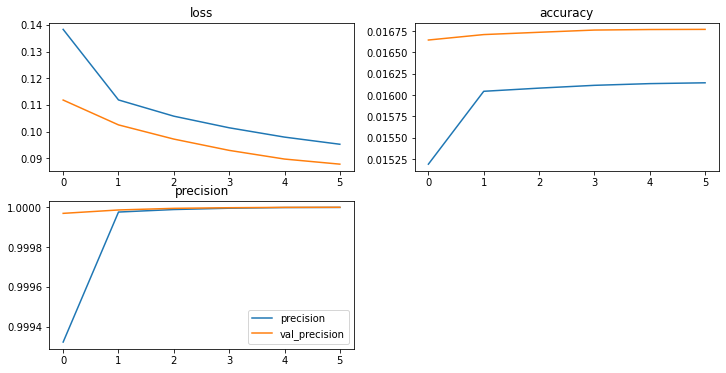

In [22]:
metrics = ['loss','accuracy', 'precision']
plt.figure(figsize = (12, 6))
for i in range(3):
    plt.subplot(2, 2, (i + 1))
    plt.plot(history.history['{}'.format(metrics[i])], label = '{}'.format(metrics[i]))
    plt.plot(history.history['val_{}'.format(metrics[i])], label = 'val_{}'.format(metrics[i]))
    plt.title('{}'.format(metrics[i]))
plt.legend()

In [25]:
G.save('./weights/final_stego_generator.h5')

In [26]:
G = tf.keras.models.load_model('./weights/final_stego_generator.h5')

In [27]:
stego_pred = G.predict(testCover)
stego_pred = (stego_pred >= 0.5).astype('int')

19/19 [==============================] - 100s 5s/step


In [28]:
average_accuracy = np.mean(history.history['accuracy'])
average_val_accuracy = np.mean(history.history['val_accuracy'])
average_precision = np.mean(history.history['precision'])
average_val_precision = np.mean(history.history['val_precision'])
print(average_accuracy, average_val_accuracy, average_precision, average_val_precision)

0.01595098540807764 0.016732279521723587 0.9998797277609507 0.9999909301598867


### Función para mostrar las imágenes generadas por el generador

In [33]:
def draw(cover, stego, y_pred):
  plt.figure(figsize = (12, 50))
  index = -1
  n = np.random.randint(y_pred.shape[0])
  for i in range(120):
    plt.subplot(20, 6, (i + 1))
    if index == -1:
      plt.imshow(cover[n], cmap = 'gray')
      plt.title('portada')
      index = 0
    elif index == 0:
      plt.imshow(cover[n], cmap = 'gray')
      plt.imshow(stego[n], alpha = 0.6, cmap = 'gray')
      plt.title('Estego original')
      index = 1
    elif index == 1:
      plt.imshow(cover[n], cmap = 'gray')
      plt.imshow(np.reshape(y_pred[n], (256, 256)), alpha = 0.6, cmap = 'gray')
      plt.title('Pred estego')
      index = -1
      n = np.random.randint(y_pred.shape[0])
  plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


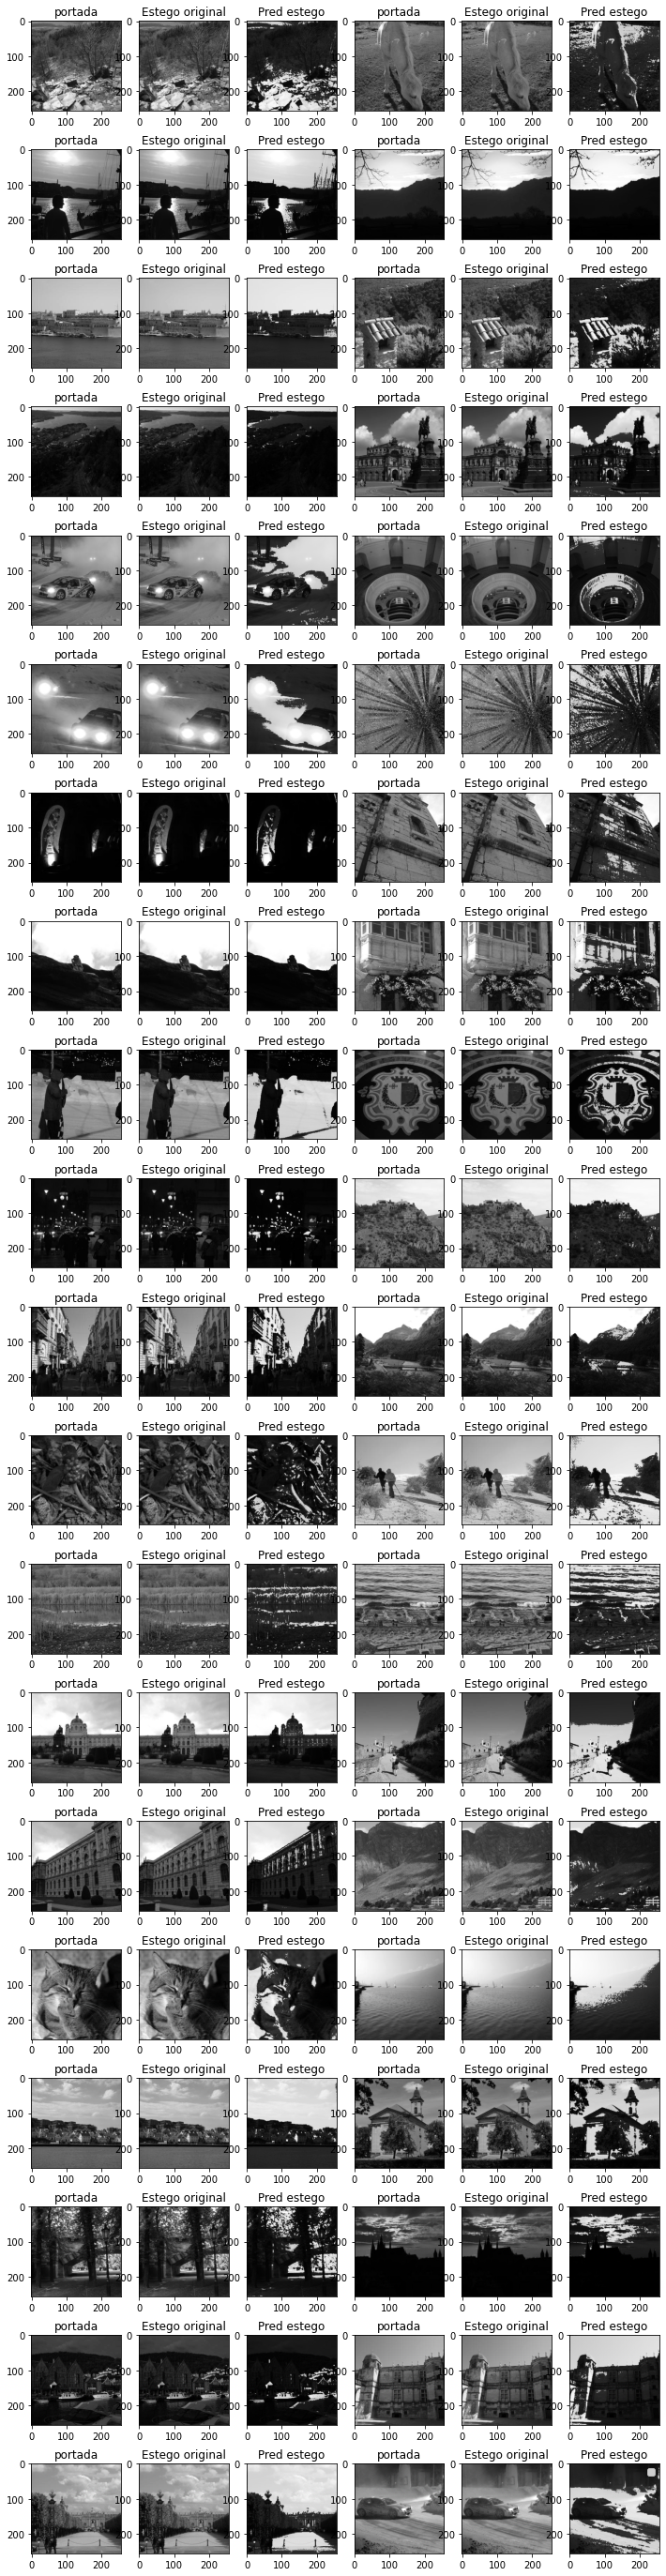

In [30]:
draw(testCover, testStego, stego_pred)

### Entrenamiento usando Algoritmos Genéticos

In [26]:
def fitness_func(ga_instance, solution, sol_idx):
    global trainCover, trainStego, keras_ga, gaGenerator

    model_weights_matrix = pygad.kerasga.model_weights_as_matrix(model=gaGenerator, weights_vector=solution)

    gaGenerator.set_weights(weights=model_weights_matrix)

    predic = gaGenerator.predict(trainCover)
    predictions = np.squeeze(predic)

    cce = tf.keras.losses.BinaryFocalCrossentropy()
    solution_fitness = 1.0 / (cce(trainStego, predictions).numpy() + 0.00000001)

    return solution_fitness

In [27]:
def callback_generation(ga_instance):
    print("Generation : ", ga_instance.generations_completed)
    print("Fitness of the best solution :", ga_instance.best_solution()[1])
    time.sleep(1)

In [28]:
keras_ga = pygad.kerasga.KerasGA(model=gaGenerator, num_solutions=3)

In [29]:
num_generations = 1 #5
num_parents_mating = 2 #3
initial_population = keras_ga.population_weights

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       on_generation=callback_generation)


C:\Users\Imanol\anaconda3\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


In [30]:
ga_instance.run()

91/91 [==============================] - 434s 5s/step
Generation :  1
91/91 [==============================] - 466s 5s/step
Fitness of the best solution : 10.383594883387186


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


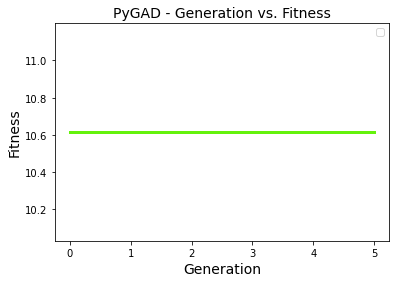

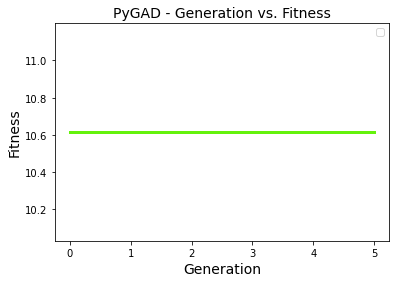

In [44]:
ga_instance.plot_fitness()

In [31]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
# Obtener los parámetros de la mejor solución
best_solution_weights = pygad.kerasga.model_weights_as_matrix(model=gaGenerator, weights_vector=solution)
gaGenerator.set_weights(best_solution_weights)

print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

91/91 [==============================] - 485s 5s/step
Fitness value of the best solution = 10.383594883387186
Index of the best solution : 0


In [32]:
predictions = gaGenerator.predict(testCover)

19/19 [==============================] - 93s 5s/step


In [47]:
# Calcular la precisión de clasificación del modelo entrenado
ca = tf.keras.metrics.BinaryAccuracy()
ca.update_state(testCover, predictions)
accuracy = ca.result().numpy()
print("Accuracy : ", accuracy)

Accuracy :  0.0166657


In [48]:
m = tf.keras.metrics.Precision()
m.update_state(testCover, predictions)
print('Precision: ', m.result().numpy())  

Precision:  0.9999996


### Las imágenes generadas por el generador después del entrenamiento mediante algoritmos genéticos 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


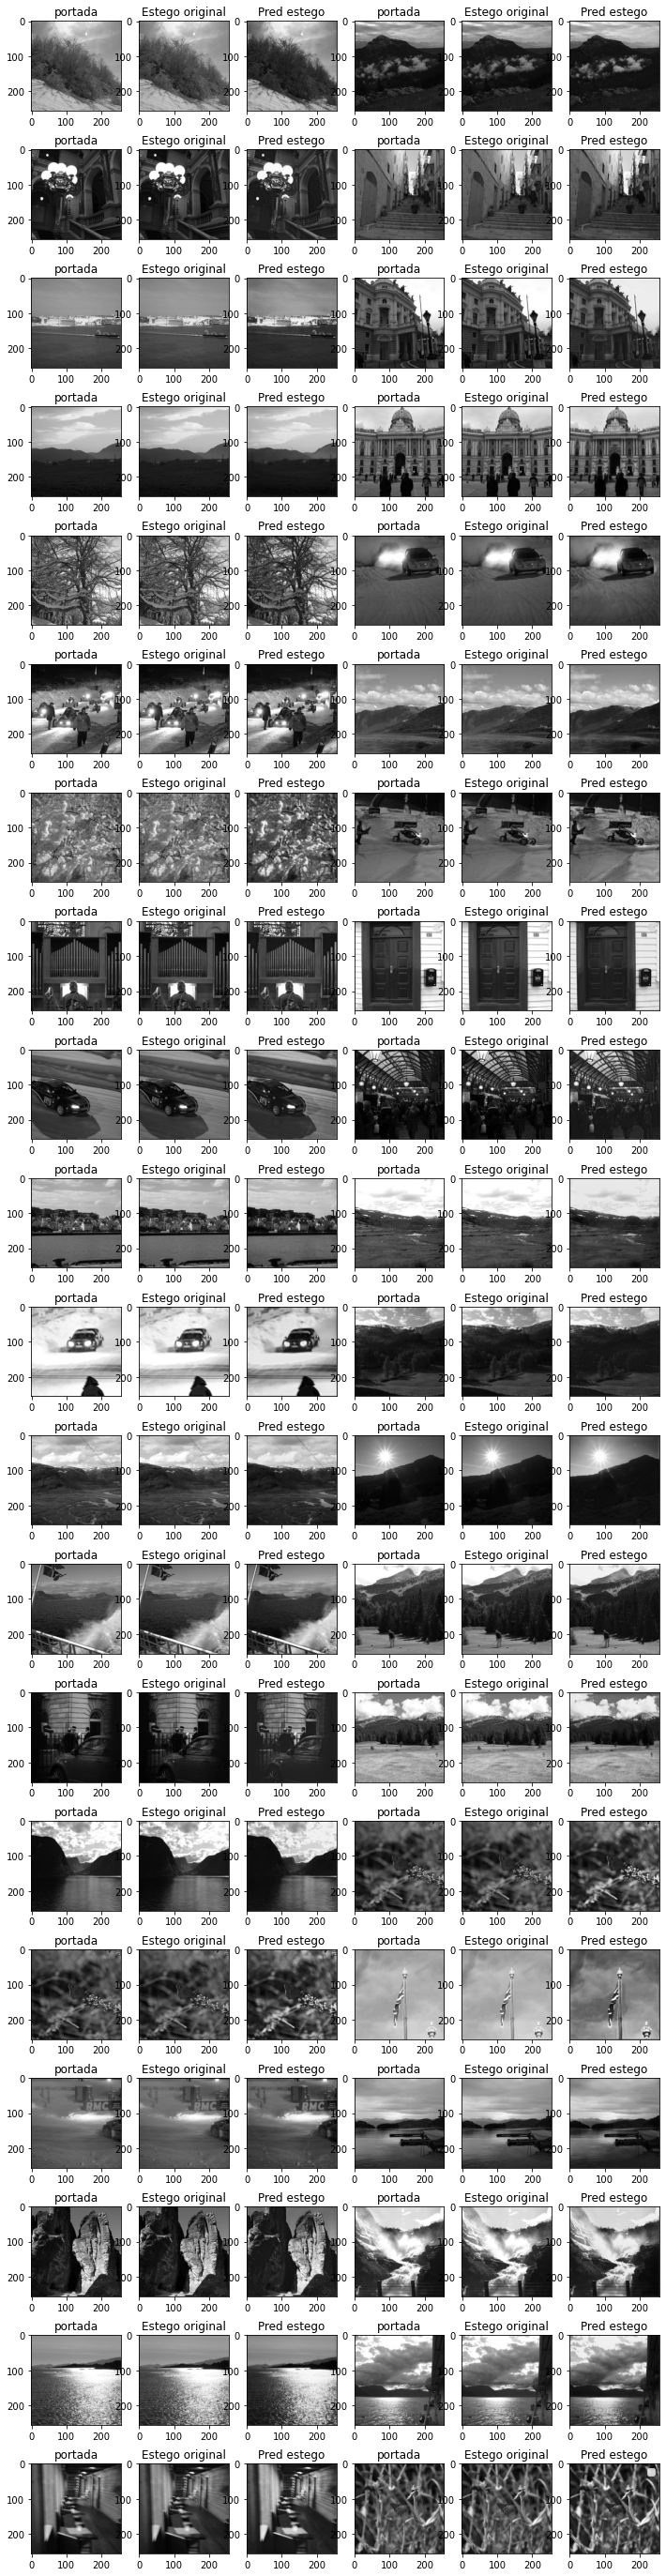

In [38]:
draw(testCover, testStego, predictions)

### Calcular el PSNR de las imagenes generadas

In [39]:
from math import log10, sqrt 
  
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE es cero significa que no hay ruido en la señal . 
                  # Por lo tanto, PSNR no tiene importancia. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [40]:
def psnrEv(cover, y_pred):
    n = np.random.randint(y_pred.shape[0])
    sum = 0
    for i in range(120):
        val = PSNR(cover[n],y_pred[n])
        sum = sum + val
    sum = sum / 120
    return sum

In [41]:
print("psnr GA: ", psnrEv(testCover, predictions))

psnr GA:  58.71808930861426


In [33]:
print("psnr GAN:", psnrEv(testCover, stego_pred))

psnr GAN: 53.5099665177085
